In [2]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
cancer = load_breast_cancer()

In [4]:
pd.DataFrame(cancer.data,columns=cancer.feature_names).head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [5]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
vo_clf = VotingClassifier([('LR',lr_clf),
                           ('KNN',knn_clf)],
                           voting='soft')
x_train, x_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    test_size=0.2,
                                                    random_state=156)
vo_clf.fit(x_train,y_train)
pred = vo_clf.predict(x_test)
accuracy_score(y_test,pred)

0.956140350877193

In [6]:
lr_clf.fit(x_train,y_train)
pred_l = lr_clf.predict(x_test)

knn_clf.fit(x_train,y_train)
pred_k = knn_clf.predict(x_test)

accuracy_score(y_test,pred_l), accuracy_score(y_test,pred_k)

(0.9473684210526315, 0.9385964912280702)

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
def get_new_feature_name_df(old):
    df = pd.DataFrame(data=old.groupby('column_name').cumcount(),
                 columns=['dup_cnt'])
    df = df.reset_index()
    new_df = pd.merge(old.reset_index(),df,how='outer')
    new_df['column_name'] = new_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) 
                                            if x[1] > 0 
                                            else x[0] ,axis=1)
    new_df.drop(columns=['index'],inplace=True)
    return new_df #new_df x[0]=(column_name) x[1]=(dup_cnt)

def get_human_dataset():
    feature_name_df = pd.read_csv('human_activity/features.txt', 
          sep='\s+',
          header=None,
          names=['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    x_train = pd.read_csv('human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    x_test = pd.read_csv('human_activity/test/X_test.txt',sep='\s+',names=feature_name)
    y_train = pd.read_csv('human_activity/train/y_train.txt',sep='\s+',names=['action'])
    y_test = pd.read_csv('human_activity/test/y_test.txt',sep='\s+',names=['action'])
    return x_train,x_test,y_train,y_test

In [9]:
x_train,x_test,y_train,y_test = get_human_dataset()

In [10]:
# 0.8547675602307431
# 0.9253478113335596
rf_clf = RandomForestClassifier(random_state=0, n_estimators=500)
rf_clf.fit(x_train,y_train)
pred = rf_clf.predict(x_test)
accuracy_score(y_test,pred)

C:\Users\admin\AppData\Local\Temp\ipykernel_1452\1664790705.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train,y_train)


0.9284017645062775

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
%%time
param = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_split':[8,16,20],
    'min_samples_leaf':[8,12,18],
}
rf_clf = RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf,param_grid=param,cv=2,n_jobs=-1)
grid_cv.fit(x_train,y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)

C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.9179815016322089
CPU times: total: 13.6 s
Wall time: 37.3 s


In [13]:
rf_clf = RandomForestClassifier(random_state=0,
                                n_estimators=100,
                                max_depth=10,
                                min_samples_leaf=8,
                                min_samples_split=8)
rf_clf.fit(x_train,y_train)
pred = rf_clf.predict(x_test)
accuracy_score(y_test,pred)

C:\Users\admin\AppData\Local\Temp\ipykernel_1452\2317208821.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train,y_train)


0.9195792331184255

In [14]:
rf_clf.feature_importances_

array([6.81829742e-05, 2.08494342e-04, 8.94806631e-05, 6.27464173e-03,
       1.56609891e-04, 1.58430547e-04, 3.62381491e-03, 2.99904093e-04,
       1.88107333e-04, 1.21137343e-02, 9.02151479e-05, 1.35527484e-04,
       4.04394593e-04, 1.27620939e-04, 1.83763855e-04, 3.23590641e-04,
       3.00538873e-03, 4.35552381e-04, 2.90218686e-04, 1.56951898e-03,
       2.15203892e-04, 1.62651304e-04, 1.17228437e-03, 8.24659962e-05,
       3.39035531e-04, 1.30765816e-04, 7.92927225e-05, 2.00672807e-05,
       1.33793856e-04, 2.49567426e-04, 6.31810274e-05, 3.80923841e-05,
       1.37341896e-04, 4.69229198e-05, 6.29444912e-05, 5.25527763e-05,
       8.42910839e-05, 5.26013328e-03, 8.24200614e-04, 2.71049206e-03,
       2.57414060e-02, 3.04199233e-02, 9.19758794e-03, 2.84817306e-03,
       1.68584106e-03, 1.95726135e-04, 6.66730938e-04, 9.81407633e-04,
       1.29240587e-04, 2.39266808e-02, 2.34528119e-02, 1.13118817e-02,
       2.82951882e-02, 2.33103365e-02, 9.26215166e-03, 4.64743478e-03,
      

In [15]:
import numpy as np
np.round(rf_clf.feature_importances_,2)

array([0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.03, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.01, 0.03, 0.02, 0.01,
       0.  , 0.03, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01,
       0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

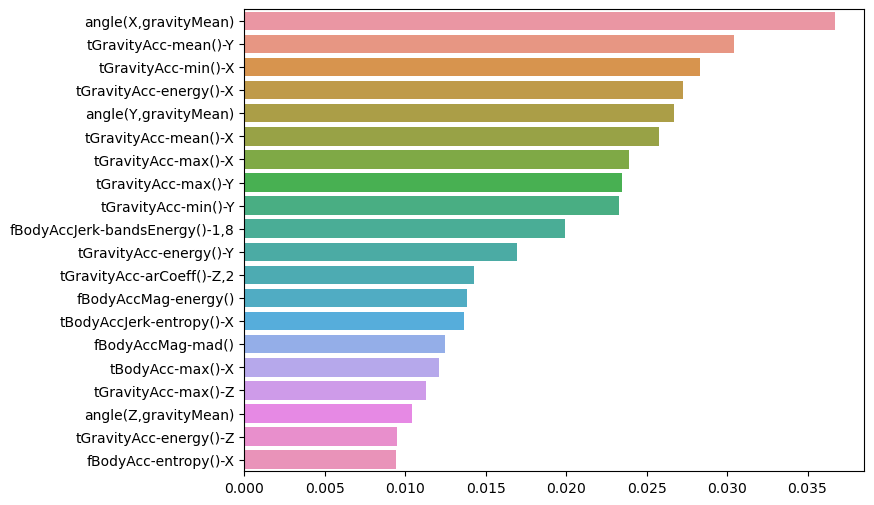

In [21]:
ftr_im = rf_clf.feature_importances_
ftr_im_s = pd.Series(ftr_im,index=x_train.columns)
top20 = ftr_im_s.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
sns.barplot(x=top20,y=top20.index)
plt.show()

In [16]:
data = pd.Series(rf_clf.feature_importances_,
          index=x_train.columns)

In [17]:
data

tBodyAcc-mean()-X                       0.000068
tBodyAcc-mean()-Y                       0.000208
tBodyAcc-mean()-Z                       0.000089
tBodyAcc-std()-X                        0.006275
tBodyAcc-std()-Y                        0.000157
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.000256
angle(tBodyGyroJerkMean,gravityMean)    0.000376
angle(X,gravityMean)                    0.036706
angle(Y,gravityMean)                    0.026723
angle(Z,gravityMean)                    0.010401
Length: 561, dtype: float64

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
%%time
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train,y_train.values.ravel()) # 경고메세지안뜨게하는거 values.ravel() 붙여줌
pred = gb_clf.predict(x_test)
accuracy_score(y_test,pred)

C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 11min 28s
Wall time: 11min 30s


0.9389209365456397

In [26]:
y_train.values.ravel()

array([5, 5, 5, ..., 2, 2, 2], dtype=int64)

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
%%time
params = {
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv = GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
grid_cv.fit(x_train,y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\admin\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

{'learning_rate': 0.05, 'n_estimators': 500}
0.9001632208922742
CPU times: total: 2h 45min 7s
Wall time: 2h 59min 48s


In [28]:
gb_pred = grid_cv.best_estimator_.predict(x_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print('GBM 정확도:{0:.4f}'.format(gb_accuracy))

GBM 정확도:0.9393
